In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix

import transformers as ppb # pytorch-pretrained-bert
import torch

import pipeline as pp
import models as ml

import importlib

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\madsv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Global variables

In [54]:

# The number of rows to train the model
BATCH_SIZE = 1000

In [55]:
data = pp.apply_pipeline("../datasets/sample/dataset.csv", None, get_batch=True, batch_size=BATCH_SIZE)

Statistics

In [57]:
# freq plot
importlib.reload(pp)
unique_words = pp.Generate_unique_word_list()
_ = pp.apply_pipeline_pd_tqdm(data, [
    (pp.Tokenizer(), 'content'),
    (unique_words, 'content')
])

100%|██████████| 1000/1000 [00:00<00:00, 7631.79it/s]


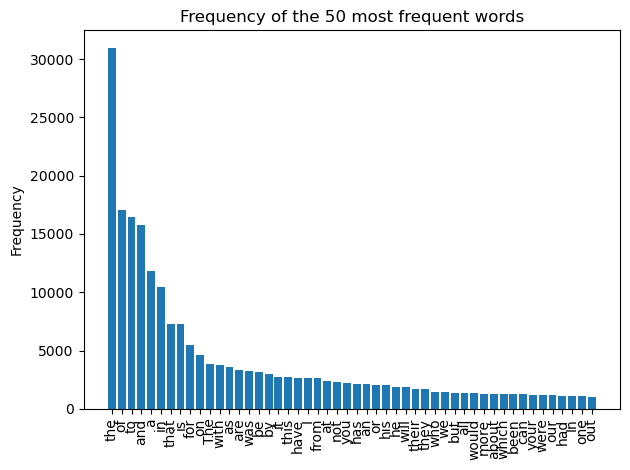

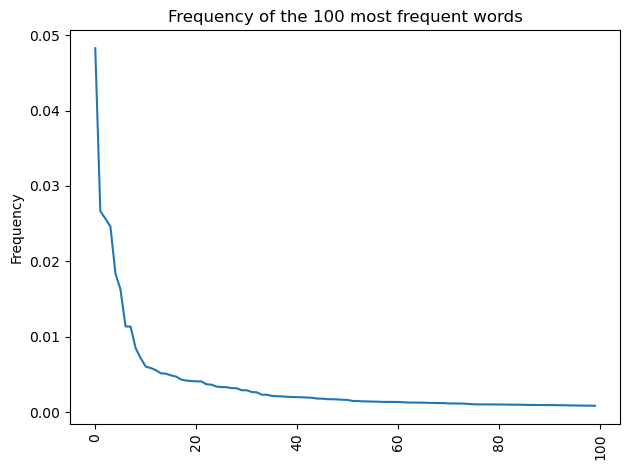

In [58]:
unique_words.plot_most_frequent(50)
unique_words.plot_frequency_line(100)

Cleaning the data

In [42]:
importlib.reload(pp)

def Clean_data(data):
    stopwords_lst = stopwords.words('english') + ["NUM","DATE","URL","EMAIL"]
    cleaned_data = pp.apply_pipeline_pd_tqdm(data, [
            (pp.Binary_labels(), 'type'),
            (pp.Clean_data(), 'content'),
            (pp.Tokenizer(), "content"),
            (pp.Remove_stopwords(stopwords_lst), "content"),
            (pp.Stem(), "content"),
        ])

    return cleaned_data


cleaned_data = Clean_data(data)

100%|██████████| 100000/100000 [10:13<00:00, 163.04it/s]


Creating a list of all words

In [32]:
importlib.reload(pp)

def Get_unique_words(cleaned_data, high, low):
    unique_words = pp.Generate_unique_word_list()
    pp.apply_pipeline_pd_tqdm(cleaned_data, [
        (unique_words, "content")
    ])
    return unique_words

unique_words = Get_unique_words(cleaned_data, 1, 0.1)

100%|██████████| 10000/10000 [00:30<00:00, 331.78it/s]


In [ ]:
print(unique_words.get_freqs())
print(unique_words.get_most_frequent(1000))
unique_words.plot_most_frequent(50)
unique_words.plot_frequency_line(10000)

In [7]:
unique_words_list = unique_words.get_unique_words(0,1)
print("words (features):", len(unique_words_list))

words (features): 20924


Bag of words representation BoW

In [33]:
importlib.reload(pp)

def Vectorize_content(cleaned_data, unique_words):
    vectors = pp.apply_pipeline_pd_tqdm(cleaned_data, [
        (pp.Create_word_vector(unique_words), "content")
    ])
    return vectors


vectors = Vectorize_content(cleaned_data, unique_words_list)

100%|██████████| 10000/10000 [03:01<00:00, 55.05it/s]


In [34]:
def test_split(data, test_size = 0.4):
    X_train, X_test, y_train, y_test = train_test_split(csr_matrix(np.stack(data["content"])), data["type"].astype(int), test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

In [35]:
X_train_vector, X_test_vector, y_train_vector, y_test_vector = test_split(vectors)

Bag of words with term frequency

In [36]:
importlib.reload(pp)
vectors_normalized = pp.apply_pipeline_pd_tqdm(vectors, [(pp.Normalize(), "content")])
X_train_vector_normalized, X_test_vector_normalized, y_train_vector_normalized, y_test_vector_normalized = test_split(vectors_normalized)

100%|██████████| 10000/10000 [00:27<00:00, 359.72it/s]


TfidfVectorizer performs the following operations:
* <strong>Tokenization:</strong> It breaks the text into individual words or tokens.
* <strong>Counting:</strong> It counts the number of occurrences of each token in each document.
* <strong>Normalization:</strong> It calculates the frequency of each token in each document by dividing the count by the total number of tokens in the document.
* <strong>Weighting:</strong> It applies the Tfidf weighting scheme to each token in each document. The Tfidf weight of a token in a document is proportional to its frequency in the document, but inversely proportional to its frequency in the corpus (i.e., the collection of all documents).

In [37]:
def Vectorize(file, to_csv_file_name=None):

    cleaned_data = pp.apply_pipeline(file, [
            (pp.binary_labels(), 'type'),
            (pp.Clean_data(), 'content')
        ], 
        get_batch=True, 
        batch_size=BATCH_SIZE)

    print("Shape of data: ", cleaned_data.shape)

    #TODO: how to avoid leaking information from the test set? 
    vect = TfidfVectorizer(stop_words='english', max_df=0.7)
    vect.fit(cleaned_data['content'])
    
    print("Vocabulary: ", len(vect.vocabulary_), " words")
    content_tfidf = vect.transform(cleaned_data['content'])
    print("Shape of vect: ", content_tfidf.shape)

    vectorized_data = {
        "X": content_tfidf,
        "y": cleaned_data['type']
    }

    if to_csv_file_name != None:
        content_tfidf_df = pd.DataFrame(content_tfidf.todense(),columns = vect.get_feature_names_out())
        content_tfidf_df.to_csv(to_csv_file_name, index=False)

    print("Done vectorizing data!")
    return vectorized_data

vectorized_data = Vectorize("../datasets/sample/dataset.csv")

Shape of data:  (10000, 18)
Vocabulary:  109205  words
Shape of vect:  (10000, 109205)
Done vectorizing data!


In [79]:
X_train, X_test, y_train, y_test = train_test_split(vectorized_data["X"], vectorized_data["y"].astype(int), test_size=0.40, random_state=42)

Comparing test data

In [39]:
print("Dim of tfidf vectorized data: ", X_train.shape, type(X_train))
print("Dim of own vectorized data: ", X_train_vector.shape, type(X_train_vector))

Dim of tfidf vectorized data:  (6000, 109205) <class 'scipy.sparse._csr.csr_matrix'>
Dim of own vectorized data:  (6000, 20924) <class 'scipy.sparse._csr.csr_matrix'>


Support vector classifier

In [40]:
def support_vector_classifier(X_train, X_test, y_train, y_test):
    # Define the classifier classes
    svc = SVC(kernel='linear')

    # Fit the model
    svc.fit(X_train, y_train)

    # Predict on the test set
    svc_pred = svc.predict(X_test)

    # Evaluate performance
    print("svc accuracy: " + str(accuracy_score(y_test, svc_pred)))

In [41]:
support_vector_classifier(X_train, X_test, y_train, y_test)

svc accuracy: 0.808


In [42]:
support_vector_classifier((X_train_vector), (X_test_vector), y_train_vector, y_test_vector)

svc accuracy: 0.7545


K neighbors classifier

In [43]:
def k_neighbors_classifier(X_train, X_test, y_train, y_test):
    # Define the classifier classes
    k_nearest = KNeighborsClassifier(n_neighbors=15, weights='distance')

    # Fit the model
    k_nearest.fit(X_train, y_train)

    # Predict on the test set
    k_nearest_pred = k_nearest.predict(X_test)

    # Evaluate performance
    print("k_nearest accuracy:", accuracy_score(y_test, k_nearest_pred))


In [44]:
k_neighbors_classifier(X_train, X_test, y_train, y_test)

k_nearest accuracy: 0.46975


In [45]:
k_neighbors_classifier(X_train_vector, X_test_vector, y_train_vector, y_test_vector)

k_nearest accuracy: 0.55525


Passive aggresive classifier

In [46]:
def passive_aggressive_classifier(X_train, X_test, y_train, y_test):
    # Define the classifier classes
    passive_aggressive = PassiveAggressiveClassifier()

    # Fit the model
    passive_aggressive.fit(X_train, y_train)

    # Predict on the test set
    passive_aggressive_pred = passive_aggressive.predict(X_test)

    # Evaluate performance
    print("passive_aggressive accuracy:", accuracy_score(y_test, passive_aggressive_pred))

In [47]:
passive_aggressive_classifier(X_train, X_test, y_train, y_test)

passive_aggressive accuracy: 0.80425


In [48]:
passive_aggressive_classifier(X_train_vector, X_test_vector, y_train_vector, y_test_vector)

passive_aggressive accuracy: 0.764


Distribution of classes in train set

In [49]:
unique, counts = np.unique(y_train, return_counts=True)
total = sum(counts)
print("counts: ", dict(zip(unique, counts)))
print("count freq", dict(zip(unique, counts/total)))

counts:  {0: 2423, 1: 3577}
count freq {0: 0.4038333333333333, 1: 0.5961666666666666}


Word embeddings

In [1]:
BATCH_SIZE = 100

In [69]:
data_embeddings = pp.apply_pipeline("../datasets/sample/dataset.csv", [(pp.binary_labels(), "type")], get_batch=True, batch_size=BATCH_SIZE)

In [70]:
def distilBERT(data):
    content = data['content']

    #Tokenizer and model input
    pretrained_weights = 'distilbert-base-uncased'
    tokenizer = ppb.DistilBertTokenizer.from_pretrained(pretrained_weights)
    model = ppb.DistilBertModel.from_pretrained(pretrained_weights, from_tf=True)

    #Tokenize input
    tokenized = content.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    model.eval()

    #Pad input so that all sequences are of the same size:
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    padded = padded[:,:32]

    # Tell embedding model to disregard pad tokens
    attention_mask = np.where(padded != 0, 1, 0)
    
    device = torch.device("cpu")

    if torch.cuda.is_available():
      model = model.cuda()
      device = torch.device("cuda")

    # Convert input to a pytorch tensor
    input = torch.tensor(np.array(padded), device=device)
    attention_mask = torch.tensor(attention_mask, device=device)

    # Embed sequences (processing in batches to avoid memory problems)
    batch_size= 200
    embeddings = []

    for start_index in range(0, input.shape[0], batch_size):
      with torch.no_grad():
        # Call embedding model
        embedding = model(input[start_index:start_index+batch_size], 
                          attention_mask=attention_mask[start_index:start_index+batch_size])[0][:,0,:]
        embeddings.append(embedding)
    embeddings = torch.cat(embeddings)   # concatenate all batch outputs back into one tensor

    # Move embeddings back to numpy
    embeddings = embeddings.cpu().numpy()
    
    return embeddings
  
embeddings = distilBERT(data_embeddings)

All TF 2.0 model weights were used when initializing DistilBertModel.

All the weights of DistilBertModel were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertModel for predictions without further training.
Token indices sequence length is longer than the specified maximum sequence length for this model (1771 > 512). Running this sequence through the model will result in indexing errors


In [71]:
labels = data_embeddings['type'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

layers = [1,2,3,4,5]
layer_sizes = [2,5,8,11,14]
tuple_list = []

for layer_size in layer_sizes:
    for layer in layers:
        tuple_list.append((layer_size,) * layer)
        
inputs = {'hidden_layer_sizes': tuple_list}

# Define the classifier classes
MLP = MLPClassifier()


#Gridsearch
cross_val = GridSearchCV(MLP, inputs, n_jobs=-1, cv=5, verbose=1)

# Fit the model
cross_val.fit(X_train, y_train)

# Predict on the test set
MLP_pred = cross_val.predict(X_test)

print("multi layer peceptron accuracy:", accuracy_score(y_test, MLP_pred))


Fitting 5 folds for each of 25 candidates, totalling 125 fits
multi layer peceptron accuracy: 0.788


c:\Users\madsv\miniconda3\envs\penguin\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural network

In [82]:
X_train.shape

(6000, 109205)

In [85]:
def neural_network(X_train, X_test, y_train, y_test):
    # Define the classifier classes
    neural_network = MLPClassifier(hidden_layer_sizes=(5000,500,50), max_iter=10000, verbose=True)

    # Fit the model
    neural_network.fit(X_train, y_train)

    # Predict on the test set
    neural_network_pred = neural_network.predict(X_test)

    # Evaluate performance
    print("neural_network accuracy:", accuracy_score(y_test, neural_network_pred))

neural_network(X_train, X_test, y_train, y_test)

In [18]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load dataset
df = pp.apply_pipeline("../datasets/sample/dataset.csv", [(pp.binary_labels(), "type")], get_batch=True, batch_size=1000)

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df["content"])
sequences = tokenizer.texts_to_sequences(df["content"])
padded_sequences = pad_sequences(sequences, maxlen=1000, truncating="post")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df["type"].astype(int), test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=1000),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="sigmoid"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

# Evaluate the model
model.evaluate(X_test, y_test)

Epoch 1/30
25/25 [==============================] - 1s 14ms/step - loss: 0.7602 - accuracy: 0.4812 - val_loss: 0.6951 - val_accuracy: 0.4950
Epoch 2/30
25/25 [==============================] - 0s 8ms/step - loss: 0.6971 - accuracy: 0.5163 - val_loss: 0.6920 - val_accuracy: 0.5050
Epoch 3/30
25/25 [==============================] - 0s 8ms/step - loss: 0.6875 - accuracy: 0.5450 - val_loss: 0.6879 - val_accuracy: 0.5450
Epoch 4/30
25/25 [==============================] - 0s 7ms/step - loss: 0.6837 - accuracy: 0.5600 - val_loss: 0.6853 - val_accuracy: 0.5200
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 0.6760 - accuracy: 0.5650 - val_loss: 0.6792 - val_accuracy: 0.5600
Epoch 6/30
25/25 [==============================] - 0s 7ms/step - loss: 0.6615 - accuracy: 0.6087 - val_loss: 0.6704 - val_accuracy: 0.5700
Epoch 7/30
25/25 [==============================] - 0s 8ms/step - loss: 0.6305 - accuracy: 0.6637 - val_loss: 0.6490 - val_accuracy: 0.6750
Epoch 8/30
25/25 [=

[0.6293168067932129, 0.7799999713897705]